# Figure. Pluripotency Gene Expression

In [1]:
import copy
import os
import subprocess

import cdpybio as cpb
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import ciepy
import cardipspy as cpy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'figure_pluripotency_gene_expression'
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

Each figure should be able to fit on a single 8.5 x 11 inch page. Please do not send figure panels as individual files. We use three standard widths for figures: 1 column, 85 mm; 1.5 column, 114 mm; and 2 column, 174 mm (the full width of the page). Although your figure size may be reduced in the print journal, please keep these widths in mind. For Previews and other three-column formats, these widths are also applicable, though the width of a single column will be 55 mm.

In [2]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0, squeeze=True)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)

ext_meta = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'GSE73211.tsv'), index_col=0,
                         low_memory=False)

tpm = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv'), index_col=0,
                                 low_memory=False)
ext_tpm = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'GSE73211_tpm.tsv'), index_col=0,
                        low_memory=False)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

In [7]:
plur_markers = ['POU5F1', 'SOX2', 'NANOG', 'ZFP42', 'LIN28A']
diff_markers = ['T', 'EOMES', 'SOX17', 'FOXA2', 'GATA4', 'HAND1', 
                'CDX2', 'PAX6', 'SOX1', 'EN1']
def get_gene_id(x):
    return gene_info[gene_info.gene_name == x].index[0]
plur_markers = pd.Series(plur_markers, index=[get_gene_id(x) for x in plur_markers])
diff_markers = pd.Series(diff_markers, index=[get_gene_id(x) for x in diff_markers])

url = 'http://www.nature.com/nbt/journal/v33/n11/extref/nbt.3387-S5.xlsx'
scorecard = pd.read_excel(url)
scorecard = scorecard.drop(scorecard.columns[2:], axis=1)
scorecard = scorecard[scorecard.gene.apply(lambda x: x in gene_info.gene_name.values)]
scorecard.index = [get_gene_id(x) for x in scorecard.gene]
scorecard = scorecard[scorecard['class'].apply(lambda x: x in ['Mesoderm', 'Pluri'])]

tpm_all = pd.concat([tpm, ext_tpm], axis=1)

In [8]:
scorecard['class'].value_counts()

Mesoderm    25
Pluri        9
Name: class, dtype: int64

In [19]:
tdf = np.log10(tpm_all.ix[scorecard.index].T + 1)
tdf = tdf - tdf.mean()
tdf = tdf / tdf.std()

In [20]:
tdf.columns = gene_info.ix[tdf.columns, 'gene_name']
tdf.columns.name = 'Gene name'

In [21]:
ext_meta.cell_type.value_counts()

ESC           35
iPSC          21
Fibroblast    17
Name: cell_type, dtype: int64

In [22]:
colors = dict(zip(['GSE73211 {}'.format(x) for x in list(set(ext_meta.cell_type))], 
                  sns.color_palette('Set2', 7)[3:6]))
colors['CARDiPS iPSC'] = sns.color_palette('Set2', 7)[2]
colors = pd.Series(colors)
colors = pd.concat([colors, 
                    pd.Series(dict(zip(list(set(scorecard['class'])), sns.color_palette("Set2", 7))))])
colors.index = [x.replace('Pluri', 'Pluripotency') for x in colors.index]

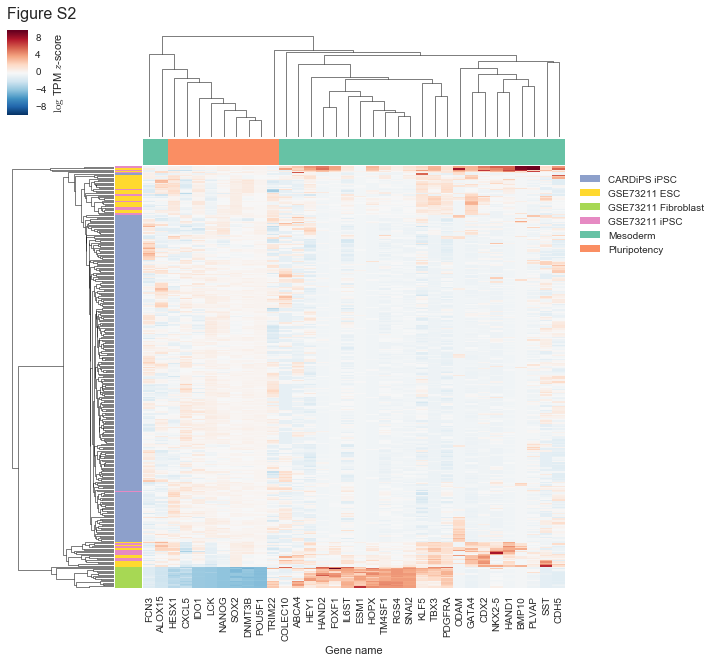

In [23]:
cs = pd.Series(dict(zip(list(set(ext_meta.cell_type)), sns.color_palette('Set2', 7)[3:])))
rc = ([sns.color_palette('Set2', 7)[2]] * tpm.shape[1]) + list(cs[ext_meta.cell_type])
cs = pd.Series(dict(zip(list(set(scorecard['class'])), sns.color_palette("Set2", 7))))
cc = cs[scorecard['class']]

cm = sns.clustermap(tdf, yticklabels=[], col_colors=cc, row_colors=rc);
cm.cax.set_ylabel('$\\log$ TPM $z$-score')
legend_rects = cpb.analysis.make_color_legend_rects(colors)
for i in colors.index:
    cm.ax_heatmap.bar(0, 0, color=colors[i],
                      label=i, linewidth=0)
cm.ax_heatmap.legend(bbox_to_anchor=(1.35, 1));
cm.cax.text(0, 1.1, 'Figure S2', size=16, va='bottom')
cm.savefig(os.path.join(outdir, 'pluri_heatmap.png'), dpi=300)